In [1]:
from collections import defaultdict
from copy import deepcopy
from dataclasses import dataclass, field
from enum import IntEnum
from functools import cached_property
from typing import Optional, Sequence, Iterator, Dict, Set, TypeVar, Union, MutableSequence

import clingo

import clingraph
from clingraph import Factbase, compute_graphs

In [2]:
class Symbol:
    pass

In [3]:
class TopLevelSymbol(Symbol):
    pass

In [4]:
@dataclass(order=True, frozen=True)
class Function(TopLevelSymbol):
    name: Optional[str] = field(default=None)
    arguments: Sequence[Symbol] = field(default_factory=tuple)

    def __str__(self):
        if self.name is None:
            return '({})'.format(','.join(map(str, self.arguments)))
        elif not self.arguments:
            return self.name
        else:
            return '{}({})'.format(self.name, ','.join(map(str, self.arguments)))

In [5]:
@dataclass(order=True, frozen=True)
class Atom:
    symbol: TopLevelSymbol = field(default_factory=Function)

    def __str__(self):
        return str(self.symbol)

In [6]:
class Literal:
    def __neg__(self):
        raise NotImplementedError

    def __abs__(self):
        raise NotImplementedError

    @property
    def is_pos(self) -> bool:
        raise NotImplementedError

    @property
    def is_neg(self) -> bool:
        raise NotImplementedError

In [7]:
class Sign(IntEnum):
    NoSign = 0
    Negation = 1

    def __str__(self):
        if self is Sign.NoSign:
            return ''
        elif self is Sign.Negation:
            return 'not'
        else:
            assert False, 'Unknown IntEnum {} = {}.'.format(self.name, self.value)

In [8]:
@dataclass(order=True, frozen=True)
class BasicLiteral(Literal):
    sign: Sign = Sign.NoSign
    atom: Atom = field(default_factory=Atom)

    def __str__(self):
        if self.sign is Sign.NoSign:
            return "{}".format(self.atom)
        else:
            return "{} {}".format(self.sign, self.atom)

    def __neg__(self):
        return BasicLiteral(Sign((self.sign ^ 1) % 2), self.atom)

    def __abs__(self):
        return BasicLiteral(Sign.NoSign, self.atom)

    @property
    def is_pos(self) -> bool:
        return self.sign is Sign.NoSign

    @property
    def is_neg(self) -> bool:
        return self.sign is Sign.Negation

In [9]:
class Rule:

    @property
    def head(self) -> BasicLiteral:
        if hasattr(self, '_head'):
            return getattr(self, '_head')
        raise NotImplementedError

    @property
    def body(self) -> Sequence[BasicLiteral]:
        if hasattr(self, '_body'):
            return getattr(self, '_body')
        raise NotImplementedError

    @staticmethod
    def fmt_body(body: Sequence[BasicLiteral]):
        return ', '.join(map(str, body))


In [10]:
@dataclass(order=True, frozen=True)
class NormalRule(Rule):
    _head: BasicLiteral = field(default_factory=BasicLiteral)
    _body: Sequence[BasicLiteral] = ()

    @property
    def head(self) -> BasicLiteral:
        return self._head

    @property
    def body(self) -> Sequence[BasicLiteral]:
        return self._body

    def __str__(self):
        if self.body:
            return "{} :- {}.".format(self.head, Rule.fmt_body(self.body))
        else:
            return "{}.".format(self.head)

In [11]:
@dataclass(order=True, frozen=True)
class IntegrityConstraint(Rule):
    _body: Sequence[BasicLiteral] = ()

    @property
    def head(self) -> bool:
        return False

    @property
    def body(self) -> Sequence[BasicLiteral]:
        return self._body

    def __str__(self):
        if self.body:
            return '#false :- {}.'.format(Rule.fmt_body(self.body))
        else:
            return '#false.'

In [12]:
@dataclass(order=True, frozen=True)
class Goal(Rule):
    _body: Sequence[BasicLiteral] = ()

    @property
    def head(self):
        return True

    @property
    def body(self) -> Sequence[BasicLiteral]:
        return self._body

    def __str__(self):
        if self.body:
            return '#true :- {}.'.format(Rule.fmt_body(self.body))
        else:
            return '#true.'

In [13]:
_ForwardBaseNode = TypeVar('_ForwardBaseNode', bound='_BaseNode')


@dataclass
class _BaseNode:
    subject: Union[Literal, Rule, None]
    hypotheses: Set[Literal]
    parent: Optional[_ForwardBaseNode]
    children: MutableSequence[_ForwardBaseNode]
    index: int

    @property
    def is_expanded(self):
        return self.children is not None

    @property
    def is_root(self):
        return self.parent is None

    @property
    def is_leaf(self):
        return self.is_expanded and not self.children

    @property
    def is_complete(self) -> bool:
        return False

    def is_exhausted(self, rules: Sequence[Rule]) -> bool:
        raise NotImplementedError

    def expand_all(self, rules: Sequence[Rule]) -> Sequence[_ForwardBaseNode]:
        raise NotImplementedError

    def expand(self, rules: Sequence[Rule]) -> Optional[_ForwardBaseNode]:
        raise NotImplementedError

    def propagate_parent(self) -> _ForwardBaseNode:
        return self.parent

In [14]:
@dataclass
class Node(_BaseNode):
    subject: Union[Literal, Rule, None] = field(default=None)
    hypotheses: Set[Literal] = field(default_factory=set)
    parent: Optional[_BaseNode] = field(default=None)
    children: Optional[MutableSequence[_BaseNode]] = field(default=None)
    index: int = field(default=0)


ForwardAndNode = TypeVar('ForwardAndNode', bound='AndNode')

In [15]:
@dataclass
class OrNode(Node):
    subject: Optional[Literal] = field(default=None)
    children: Optional[MutableSequence[ForwardAndNode]] = field(default=None)
    unfounded: bool = field(default=False)

    @property
    def is_complete(self) -> bool:
        return self.is_expanded and not self.unfounded and self.subject in self.hypotheses

    def is_exhausted(self, rules: Sequence[Rule]) -> bool:
        return self.index >= len(rules)

    def expand_all(self, rules: Sequence[Rule]) -> Sequence[ForwardAndNode]:
        self.children = []
        for rule in rules:
            if rule.head != self.subject:
                continue
            if any(-body_literal in self.hypotheses for body_literal in rule.body):
                continue
            hypotheses = deepcopy(self.hypotheses)
            hypotheses.add(self.subject)
            child = AndNode(subject=rule, hypotheses=hypotheses, parent=self)
            self.children.append(child)
        return self.children

    def expand(self, rules: Sequence[Rule]) -> Optional[ForwardAndNode]:
        assert self.subject is not None
        if not self.is_expanded:
            self.children = []
        if self.is_exhausted(rules):
            return None
        if self.unfounded:
            return None
        if -self.subject in self.hypotheses:
            return None
        if self.subject in self.hypotheses:
            node = self
            while not node.parent.is_root and node.subject.is_pos:
                node = node.parent.parent
                if node.subject == self.subject:
                    self.unfounded = True
                    return None

        rule = rules[self.index]
        if rule.head != self.subject:
            return None
        if any(-body_literal in self.hypotheses for body_literal in rule.body):
            return None
        hypotheses = deepcopy(self.hypotheses)
        hypotheses.add(self.subject)
        child = AndNode(subject=rule, hypotheses=hypotheses, parent=self)
        self.children.append(child)
        return child

    def propagate_parent(self) -> ForwardAndNode:
        hypotheses = deepcopy(self.hypotheses)
        parent = AndNode(subject=self.parent.subject,
                         hypotheses=hypotheses,
                         parent=self.parent.parent,
                         children=self.parent.children,
                         index=self.parent.index + 1)
        self.parent = parent
        return parent

In [16]:
@dataclass
class AndNode(Node):
    subject: Optional[Rule] = field(default=None)
    children: Optional[MutableSequence[OrNode]] = field(default=None)

    @property
    def is_complete(self) -> bool:
        return self.is_exhausted() and all(body_literal in self.hypotheses for body_literal in self.subject.body)

    def is_exhausted(self, rules: Sequence[Rule] = ()) -> bool:
        return self.index >= len(self.subject.body)

    def expand_all(self, rules: Sequence[Rule]) -> Sequence[OrNode]:
        self.children = []
        for body_literal in self.subject.body:
            if body_literal in self.hypotheses:
                continue
            hypotheses = deepcopy(self.hypotheses)
            child = OrNode(subject=body_literal, hypotheses=hypotheses, parent=self)
            self.children.append(child)
        return self.children

    def expand(self, rules: Sequence[Rule]) -> Optional[OrNode]:
        if not self.is_expanded:
            self.children = []
        if self.is_exhausted(rules):
            return None
        body_literal = self.subject.body[self.index]
        if body_literal.is_neg and body_literal in self.hypotheses:
            return None
        hypotheses = deepcopy(self.hypotheses)
        child = OrNode(subject=body_literal,
                       hypotheses=hypotheses,
                       parent=self)

        self.children.append(child)
        return child

    def propagate_parent(self) -> OrNode:
        hypotheses = deepcopy(self.hypotheses)
        parent = OrNode(subject=self.parent.subject,
                        hypotheses=hypotheses,
                        parent=self.parent.parent,
                        children=self.parent.children,
                        index=self.parent.index + 1)
        self.parent = parent
        return parent

In [17]:
@dataclass(order=True, frozen=True)
class Program:
    rules: Sequence[Rule] = ()

    def fmt(self, sep=' ', begin=None, end=None):
        b = begin + sep if begin is not None else ''
        e = sep + end if end is not None else ''
        return "{}{}{}".format(b, sep.join(map(str, self.rules)), e)

    def __str__(self):
        return self.fmt()

    @cached_property
    def dual(self):  # type Program
        return Program.dual_of(self.rules)

    @cached_property
    def sASP(self):
        sasp_rules = list(self.rules)
        sasp_rules.extend(self.dual_of(tuple(self.non_constraint_rules)).rules)

        dual_facts = []
        heads = set(rule.head for rule in self.reachable)
        considered = set()
        for rule in sasp_rules:
            for body_literal in rule.body:
                l = abs(body_literal)
                if l in considered:
                    continue
                if l not in heads:
                    dual_facts.append(NormalRule(-abs(body_literal)))
                    considered.add(l)

        sasp_rules.extend(dual_facts)

        chk_rules = []
        nmr_chk_head = BasicLiteral(atom=Atom(Function("__nmr_chk")))
        nmr_chk_body = []
        for i, c_rule in enumerate(self.constraint_rules):
            chk_head = BasicLiteral(atom=Atom(Function("__chk_{}_{}".format(c_rule.head.atom.symbol.name, i))))
            chk_rule_ = NormalRule(chk_head, (c_rule.head,))
            chk_rules_ = (NormalRule(chk_head, (-body_literal,)) for body_literal in c_rule.body if
                          c_rule.body != -c_rule.head)
            chk_rules.append(chk_rule_)
            chk_rules.extend(chk_rules_)
            nmr_chk_body.append(chk_head)

        sasp_rules.extend(chk_rules)
        nmr_chk_rule = NormalRule(nmr_chk_head, nmr_chk_body)
        sasp_rules.append(nmr_chk_rule)
        return Program(rules=sasp_rules)

    @cached_property
    def reachable(self) -> Dict[Rule, Set[Literal]]:
        reachable = defaultdict(set)
        for rule in self.rules:
            if not rule.body:
                reachable[rule] = set()
                continue
            considered = set()
            literal_stack = []
            naf_stack = []
            literal_stack.extend(rule.body)
            naf_stack.extend([0 for _ in rule.body])
            while literal_stack:
                literal = literal_stack.pop()
                naf = naf_stack.pop()
                naf = (naf + literal.is_neg) % 2
                reachable[rule].add(BasicLiteral(Sign(naf), literal.atom))
                for adj in self.rules:
                    if adj not in considered and adj.head == abs(literal):
                        considered.add(adj)
                        literal_stack.extend(adj.body)
                        naf_stack.extend([naf for _ in adj.body])
        return reachable

    @property
    def constraint_rules(self) -> Iterator[Rule]:
        for rule, reachable in self.reachable.items():
            if -rule.head in reachable:
                yield rule

    @property
    def non_constraint_rules(self) -> Iterator[Rule]:
        for rule, reachable in self.reachable.items():
            if rule.head in reachable or -rule.head not in reachable:
                yield rule

    def evaluate_top_down(self, *literals: Literal) -> Sequence[Node]:
        __nmr_chk = BasicLiteral(atom=Atom(Function("__nmr_chk")))
        goal = Goal((*literals, __nmr_chk))
        root = AndNode(subject=goal)
        rules = self.sASP.rules
        proofs = []
        derivation_stack = [root]
        while derivation_stack:
            current = derivation_stack.pop()
            if current.is_complete:
                if current.is_root:
                    proofs.append(deepcopy(current))
                else:
                    new_parent = current.propagate_parent()
                    derivation_stack.append(new_parent)
            elif not current.is_exhausted(rules):
                child = current.expand(rules)
                if child is None:
                    current.index += 1
                    derivation_stack.append(current)
                else:
                    if isinstance(current, OrNode):
                        current.index += 1
                        derivation_stack.append(current)
                    derivation_stack.append(child)

        return proofs

    @staticmethod
    def dual_of(rules):
        lit_rules = dict()
        for rule in rules:
            head = rule.head
            if isinstance(rule, NormalRule):
                lit_rules.setdefault(head, set()).add(rule)

        dual_rules = []
        for literal, rules in lit_rules.items():
            if isinstance(literal, bool):
                pass
            elif isinstance(literal, BasicLiteral):
                if len(rules) == 1:
                    rules = tuple(rules)
                    rule = rules[0]
                    dual_head = -literal
                    if not rule.body:
                        dual_bodies = ((),)
                    else:
                        dual_bodies = []
                        for body_literal in rule.body:
                            dual_bodies.append((-body_literal,))
                    for dual_body in dual_bodies:
                        dual_rules.append(NormalRule(dual_head, dual_body))
                elif len(rules) > 1:
                    dual_head = -literal
                    dual_body = []
                    support_dual_rules = []
                    for i, rule in enumerate(rules):
                        if len(rule.body) == 1:
                            dual_body.append(-rule.body[0])
                        elif len(rule.body) > 1:
                            support_dual_head = BasicLiteral(
                                atom=Atom(Function("__not_{}_{}".format(literal.atom.symbol.name, i))))
                            dual_body.append(support_dual_head)
                            if not rule.body:
                                support_dual_bodies = ((),)
                            else:
                                support_dual_bodies = []
                                for body_literal in rule.body:
                                    support_dual_bodies.append((-body_literal,))
                            for support_dual_body in support_dual_bodies:
                                support_dual_rules.append(NormalRule(support_dual_head, support_dual_body))
                    dual_rules.append(NormalRule(dual_head, dual_body))
                    dual_rules.extend(support_dual_rules)
        return Program(rules=dual_rules)

In [18]:
def solve(p: Program, *literals: Literal):
    proofs = p.evaluate_top_down(*literals)
    if not proofs:
        print("UNSAT")
    else:
        for i, proof in enumerate(proofs):
            print("Answer {}:".format(i), end=' ')
            print("{")
            print('\n'.join(map(str, proof.hypotheses)))
            if not proof.hypotheses:
                print(' ', end='')
            print("}")
        print("SAT {}+".format(len(proofs)))
    return proofs

def explain(proof: Node, indent=0):
    if isinstance(proof.subject, Goal):
        print('*', end='')
    print('-- ', end='')
    print(proof.subject)
    if proof.children is not None:
        for child in proof.children:
            print('  ' * indent + '|')
            print('  ' * indent + '|', end='')
            explain(child, indent+1)
    else:
        print('  ' * indent + '|')
        print('  ' * indent + '|', end='')
        if proof.is_complete:
            print('--[]')
        else:
            print('--X')

def explanation_graph(proof: Node):
    rules = []
    fb = Factbase()
    stack = [(clingo.Number(0),proof)]
    while stack:
        nr, current = stack.pop()
        string = clingo.String(str(current.subject))
        node = clingo.Function('node', (nr,))
        attr = clingo.Function('attr', (clingo.Function('node'), nr, clingo.Function('label'), string))
        rules.append("{}.".format(attr))
        if isinstance(current, AndNode):
            attr = clingo.Function('attr', (clingo.Function('node'), nr, clingo.Function('shape'), clingo.Function('box')))
            rules.append("{}.".format(attr))
        elif isinstance(current, OrNode) and current.subject.is_neg:
            attr = clingo.Function('attr', (clingo.Function('node'), nr, clingo.Function('fontcolor'), clingo.Function('white')))
            rules.append("{}.".format(attr))
            attr = clingo.Function('attr', (clingo.Function('node'), nr, clingo.Function('color'), clingo.Function('black')))
            rules.append("{}.".format(attr))
            attr = clingo.Function('attr', (clingo.Function('node'), nr, clingo.Function('style'), clingo.Function('filled')))
            rules.append("{}.".format(attr))
        rules.append('{}.'.format(node))
        if current.children is not None:
            for i,child in enumerate(current.children):
                cnr = clingo.Tuple_((nr,clingo.Number(i)))
                e = clingo.Tuple_((nr, cnr),)
                edge = clingo.Function('edge', (e,))
                attr = clingo.Function('attr', (clingo.Function('edge'), e, clingo.Function('dir'), clingo.Function('forward')))
                rules.append("{}.".format(edge))
                rules.append("{}.".format(attr))
                stack.append((cnr, child))
        elif not current.is_complete:
            if isinstance(current, OrNode):
                attr = clingo.Function('attr', (clingo.Function('node'), nr, clingo.Function('shape'), clingo.Function('doublecircle')))
            elif isinstance(current, AndNode):
                attr = clingo.Function('attr', (clingo.Function('node'), nr, clingo.Function('shape'), clingo.Function('diamond')))
            rules.append("{}.".format(attr))
    fb.add_fact_string('\n'.join(rules))
    graphs = compute_graphs(fb)
    return graphs['default']


In [19]:
encoding_str = """
:- concl,nconcl.					% consistency
concl :- prem(X), sufficient(X).	% conditional with sufficient condition
nconcl :- nprem(X), necessary(X).	% conditional with necessary condition
{prem(X); nprem(X)}1 :- hyp(X).		% hypothesis
nconcl :- nprem(e), nprem(t).		% conditional with all sufficient conditions

sufficient(e).
sufficient(t).
necessary(o).
"""


In [20]:

concl = BasicLiteral(atom=Atom(Function('concl')))
nconcl = BasicLiteral(atom=Atom(Function('nconcl')))

e = Function('e')
t = Function('t')
o = Function('o')

sufficient_e = BasicLiteral(atom=Atom(Function('sufficient', (e,))))
sufficient_t = BasicLiteral(atom=Atom(Function('sufficient', (t,))))
sufficient_o = BasicLiteral(atom=Atom(Function('sufficient', (o,))))

necessary_e = BasicLiteral(atom=Atom(Function('necessary', (e,))))
necessary_t = BasicLiteral(atom=Atom(Function('necessary', (t,))))
necessary_o = BasicLiteral(atom=Atom(Function('necessary', (o,))))

prem_e = BasicLiteral(atom=Atom(Function('prem', (e,))))
nprem_e = BasicLiteral(atom=Atom(Function('nprem', (e,))))

prem_t = BasicLiteral(atom=Atom(Function('prem', (t,))))
nprem_t = BasicLiteral(atom=Atom(Function('nprem', (t,))))

prem_o = BasicLiteral(atom=Atom(Function('prem', (o,))))
nprem_o = BasicLiteral(atom=Atom(Function('nprem', (o,))))

hyp_e = BasicLiteral(atom=Atom(Function('hyp', (e,))))
hyp_t = BasicLiteral(atom=Atom(Function('hyp', (t,))))
hyp_o = BasicLiteral(atom=Atom(Function('hyp', (o,))))

__choice_hyp_e = BasicLiteral(atom=Atom(Function('__choice', (Function('hyp', (e,)),))))
__consistency_choice_hyp_e = BasicLiteral(atom=Atom(Function('__consistency_choice', (Function('hyp', (e,)),))))
__choice_hyp_t = BasicLiteral(atom=Atom(Function('__choice', (Function('hyp', (t,)),))))
__consistency_choice_hyp_t = BasicLiteral(atom=Atom(Function('__consistency_choice', (Function('hyp', (t,)),))))
__choice_hyp_o = BasicLiteral(atom=Atom(Function('__choice', (Function('hyp', (o,)),))))
__consistency_choice_hyp_o = BasicLiteral(atom=Atom(Function('__consistency_choice', (Function('hyp', (o,)),))))

__consistency_concl = BasicLiteral(atom=Atom(Function('__consistency_concl')))

encoding_rules = (
    NormalRule(__consistency_concl, (-concl, -nconcl,)),
    NormalRule(__consistency_concl, (concl, -nconcl,)),
    NormalRule(__consistency_concl, (-concl, nconcl,)),

    NormalRule(concl, (prem_e, sufficient_e)),
    NormalRule(concl, (prem_t, sufficient_t)),
    NormalRule(concl, (prem_o, sufficient_o)),

    NormalRule(nconcl, (nprem_e, necessary_e)),
    NormalRule(nconcl, (nprem_t, necessary_t)),
    NormalRule(nconcl, (nprem_o, necessary_o)),

    NormalRule(__choice_hyp_e, (hyp_e,)),
    NormalRule(__consistency_choice_hyp_e, (-__choice_hyp_e,)),
    NormalRule(__consistency_choice_hyp_e, (__choice_hyp_e, -prem_e, -nprem_e)),
    NormalRule(__consistency_choice_hyp_e, (__choice_hyp_e, -prem_e, nprem_e)),
    NormalRule(__consistency_choice_hyp_e, (__choice_hyp_e, prem_e, -nprem_e)),

    NormalRule(__choice_hyp_t, (hyp_t,)),
    NormalRule(__consistency_choice_hyp_t, (-__choice_hyp_t,)),
    NormalRule(__consistency_choice_hyp_t, (__choice_hyp_t, -prem_t, -nprem_t)),
    NormalRule(__consistency_choice_hyp_t, (__choice_hyp_t, -prem_t, nprem_t)),
    NormalRule(__consistency_choice_hyp_t, (__choice_hyp_t, prem_t, -nprem_t)),

    NormalRule(__choice_hyp_o, (hyp_o,)),
    NormalRule(__consistency_choice_hyp_o, (-__choice_hyp_o,)),
    NormalRule(__consistency_choice_hyp_o, (__choice_hyp_o, -prem_o, -nprem_o)),
    NormalRule(__consistency_choice_hyp_o, (__choice_hyp_o, -prem_o, nprem_o)),
    NormalRule(__consistency_choice_hyp_o, (__choice_hyp_o, prem_o, -nprem_o)),

    NormalRule(nconcl, (nprem_e, nprem_t)),

    NormalRule(sufficient_e),
    NormalRule(sufficient_t),
    NormalRule(necessary_o),
)

In [21]:
ex_1_1_str = """

prem(e).			% fact
sufficient(e).		% sufficient condition
{necessary(e)}.		% possibly necessary condition

query(concl).

"""

query_concl = BasicLiteral(atom=Atom(Function('query', (Function('concl'),))))
necessary_e = BasicLiteral(atom=Atom(Function('necessary', (e,))))
not_necessary_e = BasicLiteral(atom=Atom(Function('not_necessary', (e,))))

ex_1_1_rules = (
    NormalRule(prem_e),
    NormalRule(sufficient_e),
    NormalRule(necessary_e, (-not_necessary_e,)),
    NormalRule(not_necessary_e, (-necessary_e,)),
    NormalRule(query_concl),
)
ex_1_1_p = Program(rules=(
    *encoding_rules,
    *ex_1_1_rules
))
print(ex_1_1_p.fmt(sep='\n'))

__consistency_concl :- not concl, not nconcl.
__consistency_concl :- concl, not nconcl.
__consistency_concl :- not concl, nconcl.
concl :- prem(e), sufficient(e).
concl :- prem(t), sufficient(t).
concl :- prem(o), sufficient(o).
nconcl :- nprem(e), necessary(e).
nconcl :- nprem(t), necessary(t).
nconcl :- nprem(o), necessary(o).
__choice(hyp(e)) :- hyp(e).
__consistency_choice(hyp(e)) :- not __choice(hyp(e)).
__consistency_choice(hyp(e)) :- __choice(hyp(e)), not prem(e), not nprem(e).
__consistency_choice(hyp(e)) :- __choice(hyp(e)), not prem(e), nprem(e).
__consistency_choice(hyp(e)) :- __choice(hyp(e)), prem(e), not nprem(e).
__choice(hyp(t)) :- hyp(t).
__consistency_choice(hyp(t)) :- not __choice(hyp(t)).
__consistency_choice(hyp(t)) :- __choice(hyp(t)), not prem(t), not nprem(t).
__consistency_choice(hyp(t)) :- __choice(hyp(t)), not prem(t), nprem(t).
__consistency_choice(hyp(t)) :- __choice(hyp(t)), prem(t), not nprem(t).
__choice(hyp(o)) :- hyp(o).
__consistency_choice(hyp(o)) :-

In [22]:
print(ex_1_1_p.sASP.fmt(sep='\n'))

__consistency_concl :- not concl, not nconcl.
__consistency_concl :- concl, not nconcl.
__consistency_concl :- not concl, nconcl.
concl :- prem(e), sufficient(e).
concl :- prem(t), sufficient(t).
concl :- prem(o), sufficient(o).
nconcl :- nprem(e), necessary(e).
nconcl :- nprem(t), necessary(t).
nconcl :- nprem(o), necessary(o).
__choice(hyp(e)) :- hyp(e).
__consistency_choice(hyp(e)) :- not __choice(hyp(e)).
__consistency_choice(hyp(e)) :- __choice(hyp(e)), not prem(e), not nprem(e).
__consistency_choice(hyp(e)) :- __choice(hyp(e)), not prem(e), nprem(e).
__consistency_choice(hyp(e)) :- __choice(hyp(e)), prem(e), not nprem(e).
__choice(hyp(t)) :- hyp(t).
__consistency_choice(hyp(t)) :- not __choice(hyp(t)).
__consistency_choice(hyp(t)) :- __choice(hyp(t)), not prem(t), not nprem(t).
__consistency_choice(hyp(t)) :- __choice(hyp(t)), not prem(t), nprem(t).
__consistency_choice(hyp(t)) :- __choice(hyp(t)), prem(t), not nprem(t).
__choice(hyp(o)) :- hyp(o).
__consistency_choice(hyp(o)) :-

In [23]:
proof = solve(ex_1_1_p, concl, __consistency_concl)[0]

Answer 0: {
not nprem(e)
__nmr_chk
sufficient(e)
__not_nconcl_2
prem(e)
__not_nconcl_1
__not_nconcl_0
not nprem(t)
__not_nconcl_3
not nconcl
not nprem(o)
concl
__consistency_concl
}
Answer 1: {
not nprem(e)
__nmr_chk
sufficient(e)
__not_nconcl_2
prem(e)
__not_nconcl_1
not necessary(o)
__not_nconcl_0
not nprem(t)
__not_nconcl_3
not nconcl
concl
__consistency_concl
}
Answer 2: {
not nprem(e)
__nmr_chk
sufficient(e)
__not_nconcl_2
prem(e)
__not_nconcl_1
__not_nconcl_0
not nprem(t)
__not_nconcl_3
not nconcl
not nprem(o)
concl
__consistency_concl
}
Answer 3: {
not nprem(e)
__nmr_chk
sufficient(e)
__not_nconcl_2
prem(e)
__not_nconcl_1
not necessary(o)
__not_nconcl_0
not nprem(t)
__not_nconcl_3
not nconcl
concl
__consistency_concl
}
Answer 4: {
not nprem(e)
not necessary(t)
__nmr_chk
sufficient(e)
__not_nconcl_2
prem(e)
__not_nconcl_1
__not_nconcl_0
__not_nconcl_3
not nconcl
not nprem(o)
concl
__consistency_concl
}
Answer 5: {
not nprem(e)
not necessary(t)
__nmr_chk
sufficient(e)
__not_nconcl

In [24]:
explain(proof)

*-- #true :- concl, __consistency_concl, __nmr_chk.
|
|-- concl
  |
  |-- concl :- prem(e), sufficient(e).
    |
    |-- prem(e)
      |
      |-- prem(e).
        |
        |--[]
    |
    |-- sufficient(e)
      |
      |-- sufficient(e).
        |
        |--[]
|
|-- __consistency_concl
  |
  |-- __consistency_concl :- concl, not nconcl.
    |
    |-- concl
    |
    |-- not nconcl
      |
      |-- not nconcl :- __not_nconcl_0, __not_nconcl_1, __not_nconcl_2, __not_nconcl_3.
        |
        |-- __not_nconcl_0
          |
          |-- __not_nconcl_0 :- not nprem(e).
            |
            |-- not nprem(e)
              |
              |-- not nprem(e).
                |
                |--[]
        |
        |-- __not_nconcl_1
          |
          |-- __not_nconcl_1 :- not nprem(t).
            |
            |-- not nprem(t)
              |
              |-- not nprem(t).
                |
                |--[]
        |
        |-- __not_nconcl_2
          |
          |-- _

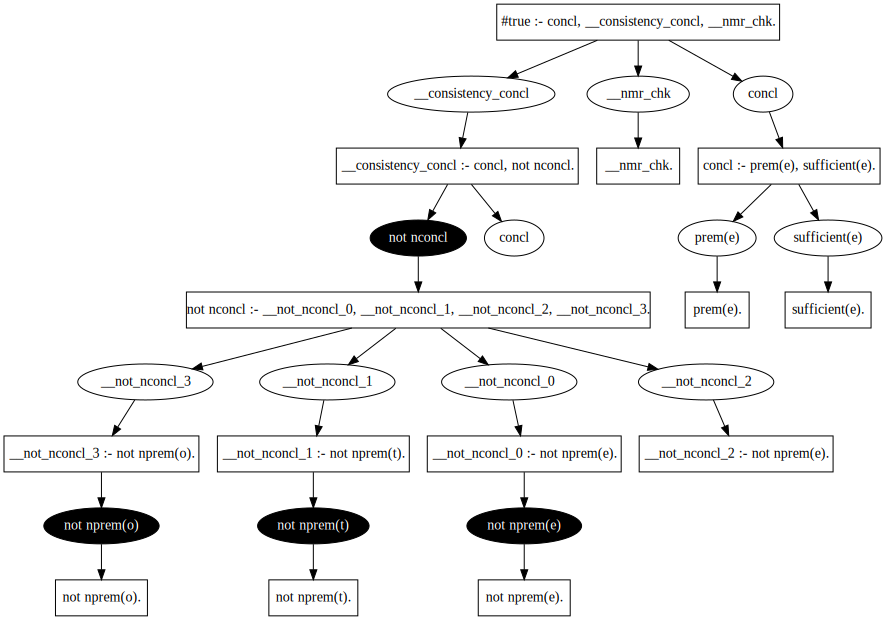

In [25]:
explanation_graph(proof)

In [26]:
proof = solve(ex_1_1_p, concl, -nprem_e, __consistency_concl)[0]

Answer 0: {
not nprem(e)
__nmr_chk
sufficient(e)
__not_nconcl_2
prem(e)
__not_nconcl_1
__not_nconcl_0
not nprem(t)
__not_nconcl_3
not nconcl
not nprem(o)
concl
__consistency_concl
}
Answer 1: {
not nprem(e)
__nmr_chk
sufficient(e)
__not_nconcl_2
prem(e)
__not_nconcl_1
not necessary(o)
__not_nconcl_0
not nprem(t)
__not_nconcl_3
not nconcl
concl
__consistency_concl
}
Answer 2: {
not nprem(e)
__nmr_chk
sufficient(e)
__not_nconcl_2
prem(e)
__not_nconcl_1
__not_nconcl_0
not nprem(t)
__not_nconcl_3
not nconcl
not nprem(o)
concl
__consistency_concl
}
Answer 3: {
not nprem(e)
__nmr_chk
sufficient(e)
__not_nconcl_2
prem(e)
__not_nconcl_1
not necessary(o)
__not_nconcl_0
not nprem(t)
__not_nconcl_3
not nconcl
concl
__consistency_concl
}
Answer 4: {
not nprem(e)
not necessary(t)
__nmr_chk
sufficient(e)
__not_nconcl_2
prem(e)
__not_nconcl_1
__not_nconcl_0
__not_nconcl_3
not nconcl
not nprem(o)
concl
__consistency_concl
}
Answer 5: {
not nprem(e)
not necessary(t)
__nmr_chk
sufficient(e)
__not_nconcl

In [27]:
explain(proof)

*-- #true :- concl, not nprem(e), __consistency_concl, __nmr_chk.
|
|-- concl
  |
  |-- concl :- prem(e), sufficient(e).
    |
    |-- prem(e)
      |
      |-- prem(e).
        |
        |--[]
    |
    |-- sufficient(e)
      |
      |-- sufficient(e).
        |
        |--[]
|
|-- not nprem(e)
  |
  |-- not nprem(e).
    |
    |--[]
|
|-- __consistency_concl
  |
  |-- __consistency_concl :- concl, not nconcl.
    |
    |-- concl
    |
    |-- not nconcl
      |
      |-- not nconcl :- __not_nconcl_0, __not_nconcl_1, __not_nconcl_2, __not_nconcl_3.
        |
        |-- __not_nconcl_0
          |
          |-- __not_nconcl_0 :- not nprem(e).
        |
        |-- __not_nconcl_1
          |
          |-- __not_nconcl_1 :- not nprem(t).
            |
            |-- not nprem(t)
              |
              |-- not nprem(t).
                |
                |--[]
        |
        |-- __not_nconcl_2
          |
          |-- __not_nconcl_2 :- not nprem(e).
        |
        |-- __not

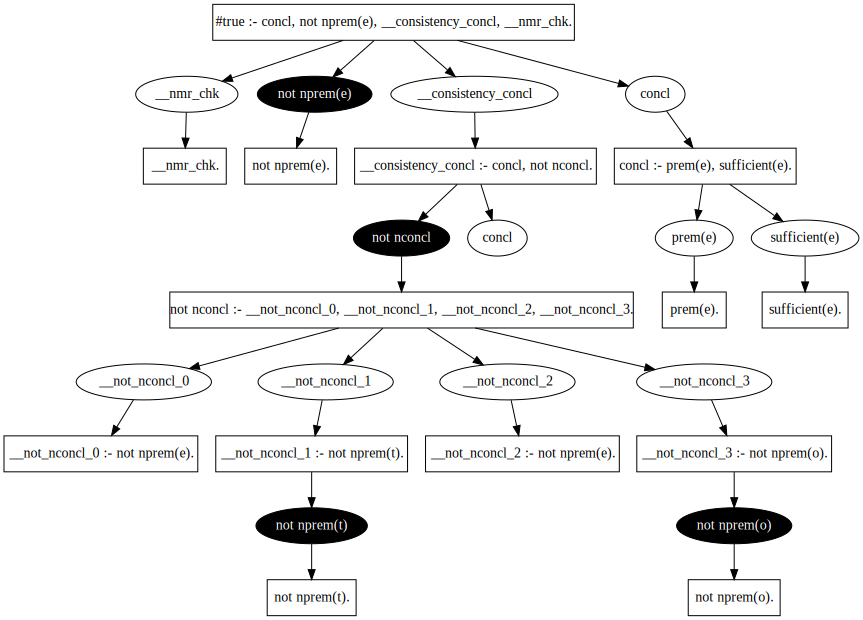

In [28]:
explanation_graph(proof)

In [29]:
proof = solve(ex_1_1_p, concl, -nprem_t, __consistency_concl)[0]

Answer 0: {
not nprem(e)
__nmr_chk
sufficient(e)
__not_nconcl_2
prem(e)
__not_nconcl_1
not nprem(t)
__not_nconcl_0
__not_nconcl_3
not nconcl
not nprem(o)
concl
__consistency_concl
}
Answer 1: {
not nprem(e)
__nmr_chk
sufficient(e)
__not_nconcl_2
prem(e)
__not_nconcl_1
not necessary(o)
not nprem(t)
__not_nconcl_0
__not_nconcl_3
not nconcl
concl
__consistency_concl
}
Answer 2: {
not nprem(e)
__nmr_chk
sufficient(e)
__not_nconcl_2
prem(e)
__not_nconcl_1
not nprem(t)
__not_nconcl_0
__not_nconcl_3
not nconcl
not nprem(o)
concl
__consistency_concl
}
Answer 3: {
not nprem(e)
__nmr_chk
sufficient(e)
__not_nconcl_2
prem(e)
__not_nconcl_1
not necessary(o)
not nprem(t)
__not_nconcl_0
__not_nconcl_3
not nconcl
concl
__consistency_concl
}
Answer 4: {
not nprem(e)
not necessary(t)
__nmr_chk
sufficient(e)
__not_nconcl_2
prem(e)
__not_nconcl_1
not nprem(t)
__not_nconcl_0
__not_nconcl_3
not nconcl
not nprem(o)
concl
__consistency_concl
}
Answer 5: {
not nprem(e)
not necessary(t)
__nmr_chk
sufficient(e)

In [30]:
explain(proof)

*-- #true :- concl, not nprem(t), __consistency_concl, __nmr_chk.
|
|-- concl
  |
  |-- concl :- prem(e), sufficient(e).
    |
    |-- prem(e)
      |
      |-- prem(e).
        |
        |--[]
    |
    |-- sufficient(e)
      |
      |-- sufficient(e).
        |
        |--[]
|
|-- not nprem(t)
  |
  |-- not nprem(t).
    |
    |--[]
|
|-- __consistency_concl
  |
  |-- __consistency_concl :- concl, not nconcl.
    |
    |-- concl
    |
    |-- not nconcl
      |
      |-- not nconcl :- __not_nconcl_0, __not_nconcl_1, __not_nconcl_2, __not_nconcl_3.
        |
        |-- __not_nconcl_0
          |
          |-- __not_nconcl_0 :- not nprem(e).
            |
            |-- not nprem(e)
              |
              |-- not nprem(e).
                |
                |--[]
        |
        |-- __not_nconcl_1
          |
          |-- __not_nconcl_1 :- not nprem(t).
        |
        |-- __not_nconcl_2
          |
          |-- __not_nconcl_2 :- not nprem(e).
        |
        |-- __not

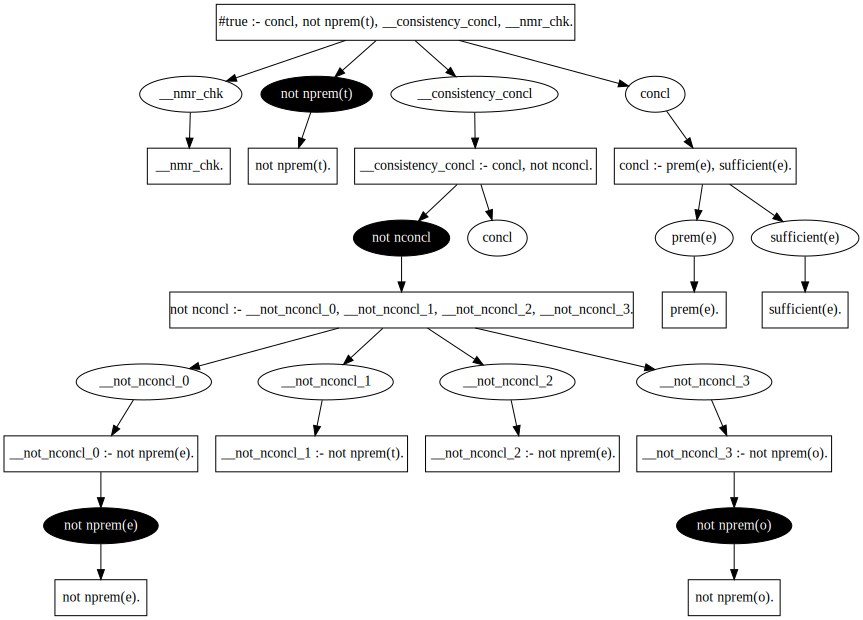

In [31]:
explanation_graph(proof)

In [32]:
solve(ex_1_1_p, nconcl, __consistency_concl);

UNSAT


In [33]:
proof = solve(ex_1_1_p, -nconcl, __consistency_concl)[0]

Answer 0: {
not nprem(e)
__nmr_chk
not concl
__not_concl_1
__not_concl_2
not prem(t)
not prem(o)
__not_nconcl_2
__not_nconcl_1
not nprem(t)
__not_nconcl_0
__not_nconcl_3
__not_concl_0
not nconcl
not nprem(o)
__consistency_concl
not prem(e)
}
Answer 1: {
not nprem(e)
__nmr_chk
not concl
__not_concl_1
__not_concl_2
not prem(t)
__not_nconcl_2
__not_nconcl_1
not nprem(t)
__not_nconcl_0
__not_nconcl_3
__not_concl_0
not sufficient(e)
not nconcl
not nprem(o)
__consistency_concl
not prem(o)
}
Answer 2: {
not nprem(e)
__nmr_chk
not concl
__not_concl_1
__not_concl_2
not prem(t)
__not_nconcl_2
__not_nconcl_1
not sufficient(o)
not nprem(t)
__not_nconcl_0
__not_nconcl_3
__not_concl_0
not nconcl
not nprem(o)
__consistency_concl
not prem(e)
}
Answer 3: {
not nprem(e)
__nmr_chk
not concl
__not_concl_1
__not_concl_2
not prem(t)
__not_nconcl_2
__not_nconcl_1
not sufficient(o)
not nprem(t)
__not_nconcl_0
__not_nconcl_3
__not_concl_0
not sufficient(e)
not nconcl
not nprem(o)
__consistency_concl
}
Answer 4

In [34]:
explain(proof)

*-- #true :- not nconcl, __consistency_concl, __nmr_chk.
|
|-- not nconcl
  |
  |-- not nconcl :- __not_nconcl_0, __not_nconcl_1, __not_nconcl_2, __not_nconcl_3.
    |
    |-- __not_nconcl_0
      |
      |-- __not_nconcl_0 :- not nprem(e).
        |
        |-- not nprem(e)
          |
          |-- not nprem(e).
            |
            |--[]
    |
    |-- __not_nconcl_1
      |
      |-- __not_nconcl_1 :- not nprem(t).
        |
        |-- not nprem(t)
          |
          |-- not nprem(t).
            |
            |--[]
    |
    |-- __not_nconcl_2
      |
      |-- __not_nconcl_2 :- not nprem(e).
    |
    |-- __not_nconcl_3
      |
      |-- __not_nconcl_3 :- not nprem(o).
        |
        |-- not nprem(o)
          |
          |-- not nprem(o).
            |
            |--[]
|
|-- __consistency_concl
  |
  |-- __consistency_concl :- not concl, not nconcl.
    |
    |-- not concl
      |
      |-- not concl :- __not_concl_0, __not_concl_1, __not_concl_2.
        |
        |

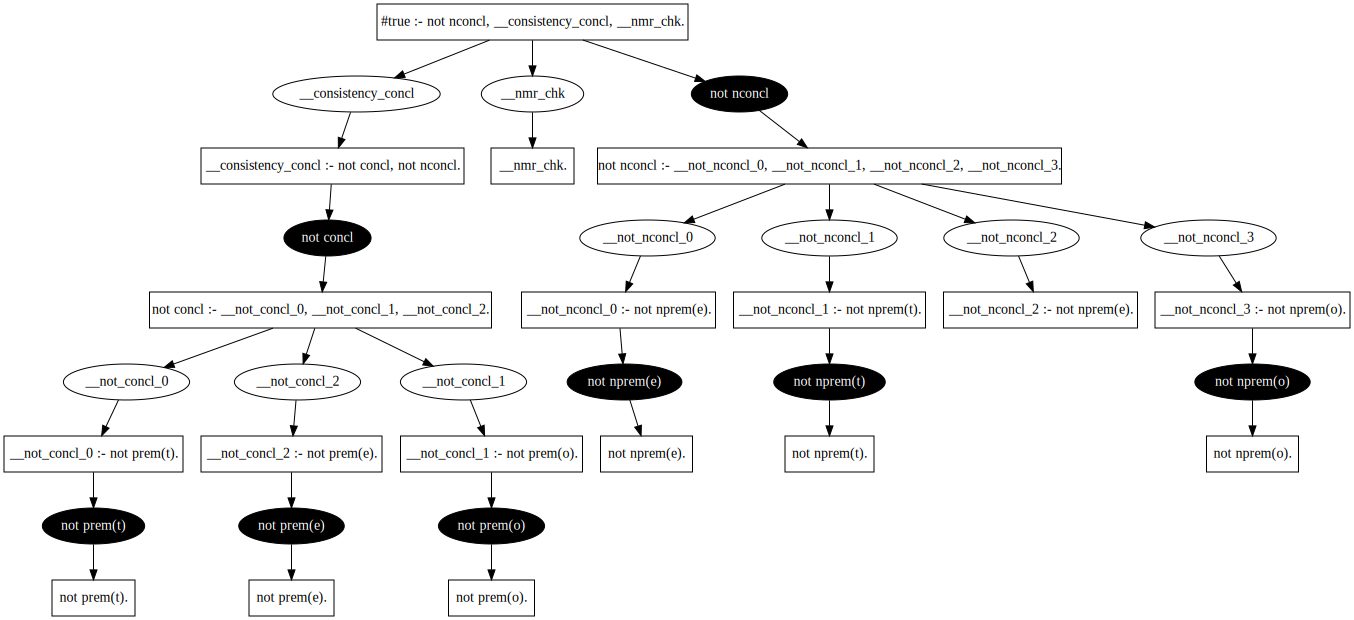

In [35]:
explanation_graph(proof)

In [36]:
ex_1_2_str = """

prem(e).
{hyp(t)}.

query(concl).

"""

hyp_t = BasicLiteral(atom=Atom(Function('hyp', (t,))))
not_hyp_t = BasicLiteral(atom=Atom(Function('not_hyp', (t,))))


ex_1_2_rules = (
    NormalRule(prem_e),
    NormalRule(hyp_t, (-not_hyp_t,)),
    NormalRule(not_hyp_t, (-hyp_t,)),
    NormalRule(query_concl),
)

ex_1_2_p = Program((
    *encoding_rules,
    *ex_1_2_rules))

print(ex_1_2_p.fmt(sep='\n'))

__consistency_concl :- not concl, not nconcl.
__consistency_concl :- concl, not nconcl.
__consistency_concl :- not concl, nconcl.
concl :- prem(e), sufficient(e).
concl :- prem(t), sufficient(t).
concl :- prem(o), sufficient(o).
nconcl :- nprem(e), necessary(e).
nconcl :- nprem(t), necessary(t).
nconcl :- nprem(o), necessary(o).
__choice(hyp(e)) :- hyp(e).
__consistency_choice(hyp(e)) :- not __choice(hyp(e)).
__consistency_choice(hyp(e)) :- __choice(hyp(e)), not prem(e), not nprem(e).
__consistency_choice(hyp(e)) :- __choice(hyp(e)), not prem(e), nprem(e).
__consistency_choice(hyp(e)) :- __choice(hyp(e)), prem(e), not nprem(e).
__choice(hyp(t)) :- hyp(t).
__consistency_choice(hyp(t)) :- not __choice(hyp(t)).
__consistency_choice(hyp(t)) :- __choice(hyp(t)), not prem(t), not nprem(t).
__consistency_choice(hyp(t)) :- __choice(hyp(t)), not prem(t), nprem(t).
__consistency_choice(hyp(t)) :- __choice(hyp(t)), prem(t), not nprem(t).
__choice(hyp(o)) :- hyp(o).
__consistency_choice(hyp(o)) :-

In [37]:
print(ex_1_2_p.sASP.fmt(sep='\n'))

__consistency_concl :- not concl, not nconcl.
__consistency_concl :- concl, not nconcl.
__consistency_concl :- not concl, nconcl.
concl :- prem(e), sufficient(e).
concl :- prem(t), sufficient(t).
concl :- prem(o), sufficient(o).
nconcl :- nprem(e), necessary(e).
nconcl :- nprem(t), necessary(t).
nconcl :- nprem(o), necessary(o).
__choice(hyp(e)) :- hyp(e).
__consistency_choice(hyp(e)) :- not __choice(hyp(e)).
__consistency_choice(hyp(e)) :- __choice(hyp(e)), not prem(e), not nprem(e).
__consistency_choice(hyp(e)) :- __choice(hyp(e)), not prem(e), nprem(e).
__consistency_choice(hyp(e)) :- __choice(hyp(e)), prem(e), not nprem(e).
__choice(hyp(t)) :- hyp(t).
__consistency_choice(hyp(t)) :- not __choice(hyp(t)).
__consistency_choice(hyp(t)) :- __choice(hyp(t)), not prem(t), not nprem(t).
__consistency_choice(hyp(t)) :- __choice(hyp(t)), not prem(t), nprem(t).
__consistency_choice(hyp(t)) :- __choice(hyp(t)), prem(t), not nprem(t).
__choice(hyp(o)) :- hyp(o).
__consistency_choice(hyp(o)) :-

In [38]:
proof = solve(ex_1_2_p, concl, __consistency_concl, __consistency_choice_hyp_t)[0]

Answer 0: {
__consistency_choice(hyp(t))
not_hyp(t)
not nprem(e)
__nmr_chk
sufficient(e)
not __choice(hyp(t))
__not_nconcl_2
prem(e)
__not_nconcl_1
not hyp(t)
__not_nconcl_0
not nprem(t)
__not_nconcl_3
not nconcl
not nprem(o)
concl
__consistency_concl
}
Answer 1: {
__consistency_choice(hyp(t))
not nprem(e)
__nmr_chk
sufficient(e)
not prem(t)
not not_hyp(t)
__not_nconcl_2
prem(e)
__not_nconcl_1
__not_nconcl_0
not nprem(t)
__not_nconcl_3
__choice(hyp(t))
not nconcl
not nprem(o)
concl
__consistency_concl
hyp(t)
}
Answer 2: {
__consistency_choice(hyp(t))
not_hyp(t)
not nprem(e)
__nmr_chk
sufficient(e)
not __choice(hyp(t))
__not_nconcl_2
prem(e)
__not_nconcl_1
not necessary(o)
not hyp(t)
__not_nconcl_0
not nprem(t)
__not_nconcl_3
not nconcl
concl
__consistency_concl
}
Answer 3: {
__consistency_choice(hyp(t))
not nprem(e)
__nmr_chk
sufficient(e)
not prem(t)
not not_hyp(t)
__not_nconcl_2
prem(e)
__not_nconcl_1
not necessary(o)
__not_nconcl_0
not nprem(t)
__not_nconcl_3
__choice(hyp(t))
not nc

In [39]:
explain(proof)

*-- #true :- concl, __consistency_concl, __consistency_choice(hyp(t)), __nmr_chk.
|
|-- concl
  |
  |-- concl :- prem(e), sufficient(e).
    |
    |-- prem(e)
      |
      |-- prem(e).
        |
        |--[]
    |
    |-- sufficient(e)
      |
      |-- sufficient(e).
        |
        |--[]
|
|-- __consistency_concl
  |
  |-- __consistency_concl :- concl, not nconcl.
    |
    |-- concl
    |
    |-- not nconcl
      |
      |-- not nconcl :- __not_nconcl_0, __not_nconcl_1, __not_nconcl_2, __not_nconcl_3.
        |
        |-- __not_nconcl_0
          |
          |-- __not_nconcl_0 :- not nprem(e).
            |
            |-- not nprem(e)
              |
              |-- not nprem(e).
                |
                |--[]
        |
        |-- __not_nconcl_1
          |
          |-- __not_nconcl_1 :- not nprem(t).
            |
            |-- not nprem(t)
              |
              |-- not nprem(t).
                |
                |--[]
        |
        |-- __not_nconcl

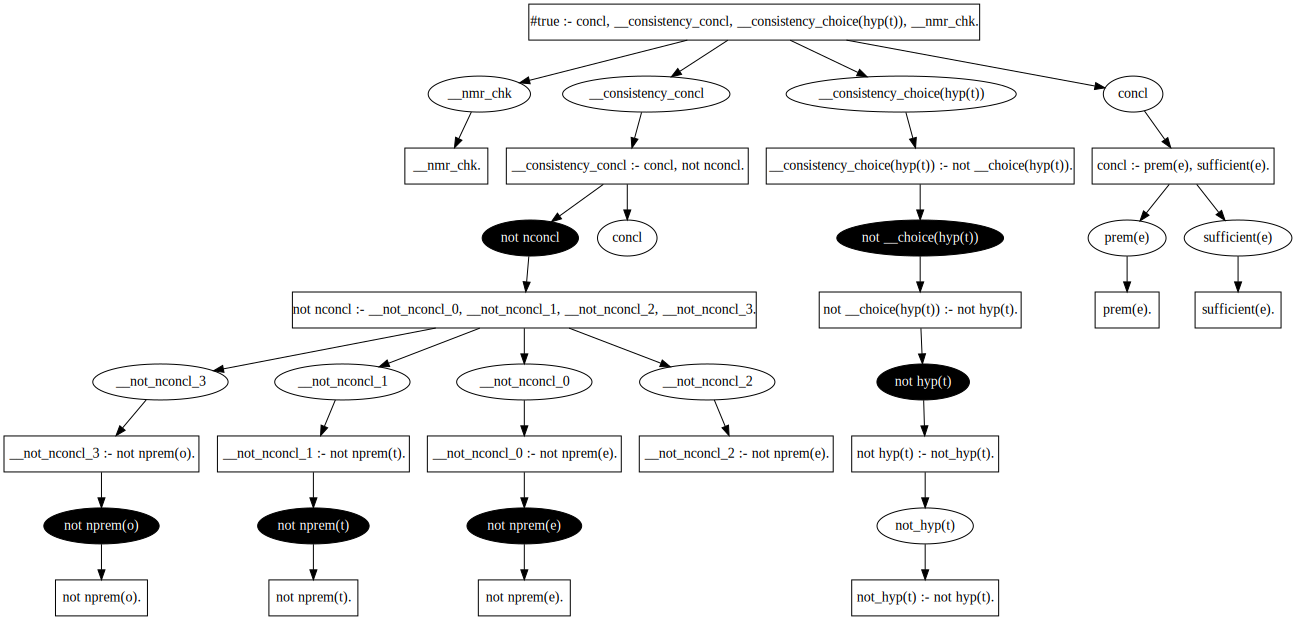

In [40]:
explanation_graph(proof)

In [ ]:
proof = solve(ex_1_2_p, __consistency_concl, __consistency_choice_hyp_t)[0]

In [ ]:
explain(proof)

In [ ]:
explanation_graph(proof)

In [ ]:
proof = solve(ex_1_2_p, concl, nprem_t)[0]

In [ ]:
explain(proof)

In [ ]:
explanation_graph(proof)

In [ ]:
ex_1_3_str = """

necessary(e).
{hyp(o);prem(e)}.

query(concl).

"""

hyp_o = BasicLiteral(atom=Atom(Function('hyp', (o,))))
not_hyp_o = BasicLiteral(atom=Atom(Function('not_hyp', (o,))))
not_prem_e = BasicLiteral(atom=Atom(Function('not_prem', (e,))))
prem_o = BasicLiteral(atom=Atom(Function('prem', (o,))))
not_prem_o = BasicLiteral(atom=Atom(Function('not_prem', (o,))))
nprem_o = BasicLiteral(atom=Atom(Function('nprem', (o,))))
not_nprem_o = BasicLiteral(atom=Atom(Function('not_nprem', (o,))))

ex_1_3_rules = (
    NormalRule(necessary_e),
    NormalRule(hyp_o, (-not_hyp_o,)),
    NormalRule(not_hyp_o, (-hyp_o,)),
    NormalRule(not_prem_e, (-not_prem_e,)),
    NormalRule(query_concl),
    NormalRule(concl, (prem_e, sufficient_e)),
    NormalRule(nconcl, (nprem_e, necessary_e)),
    NormalRule(__choice, (hyp_o,)),
    NormalRule(prem_o, (__choice, -not_prem_o)),
    NormalRule(not_prem_o, (__choice, -prem_o)),
    NormalRule(nprem_o, (__choice, -not_nprem_o)),
    NormalRule(not_nprem_o, (__choice, -nprem_o)),
    NormalRule(-prem_o, (__choice, nprem_o)),
    NormalRule(-nprem_o, (__choice, prem_o)),
)

ex_1_3_p = Program(
    (*encoding_rules,
     *ex_1_3_rules))
print(ex_1_3_p.fmt(sep='\n'))

In [ ]:
proof = solve(ex_1_3_p, concl)[0]

In [ ]:
explain(proof)

In [ ]:
explanation_graph(proof)

In [ ]:
proof = solve(ex_1_3_p, nconcl)[0]

In [ ]:
explain(proof)

In [ ]:
explanation_graph(proof)